In [13]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [14]:
env = BlackjackEnv()

In [15]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [16]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):

        # Implement this!
        
        action_values = Q[observation]
        action_probabilities = np.zeros_like(action_values)
        
        best_action = np.argmax(action_values)
        
        action_probabilities[best_action] = 1
        
        return action_probabilities
        
    return policy_fn

In [18]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    
    #Cumulative sum of the weights
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(num_episodes):
        
        #Get an episode following policy b:-
                
        
        Episode = []
        observation = env.reset()
        
        for t in range(100):
            
            action_probabs = behavior_policy(observation)
            action = np.random.choice(len(action_probabs), p=action_probabs)
            
            next_observation, reward, done, _ = env.step(action)

            Episode.append([observation, action, reward])
            
            if done:
                break
            
            observation = next_observation
    
        
        #Off Policy Control
        
        Episode_reverse = Episode
        Episode_reverse.reverse()
        
        G = 0
        W = 1
        
        for step in Episode_reverse:
            
            G = discount_factor * G + step[2]
            
            C[step[0]][step[1]] += W
            
            Q[step[0]][step[1]] += ( W/C[step[0]][step[1]] ) * ( G - Q[step[0]][step[1]] )
            
            if step[1] != np.argmax(target_policy(step[0])):
                break
            
            W *= (1/behavior_policy(step[0])[step[1]])
        
        
    return Q, target_policy

In [ ]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

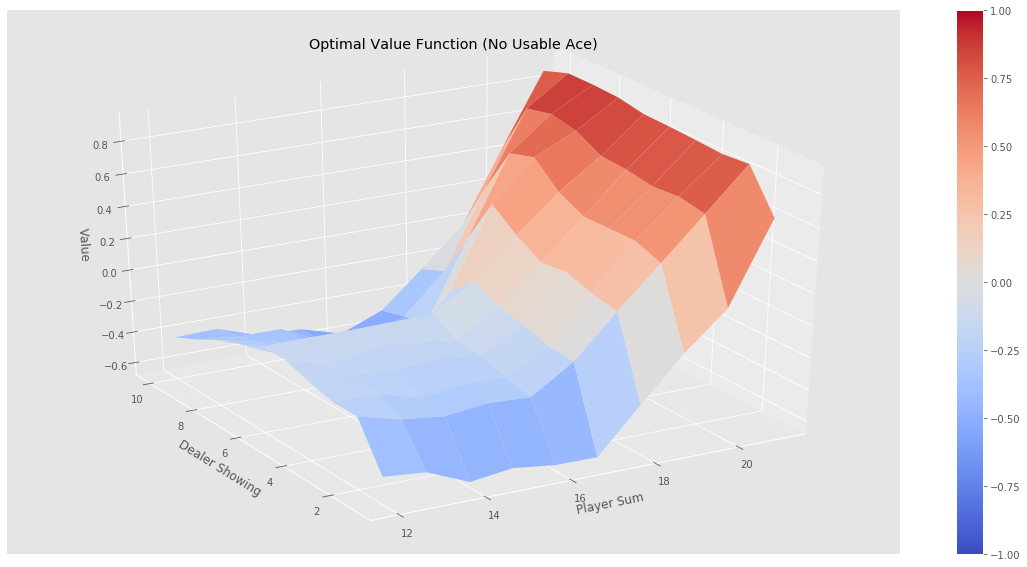

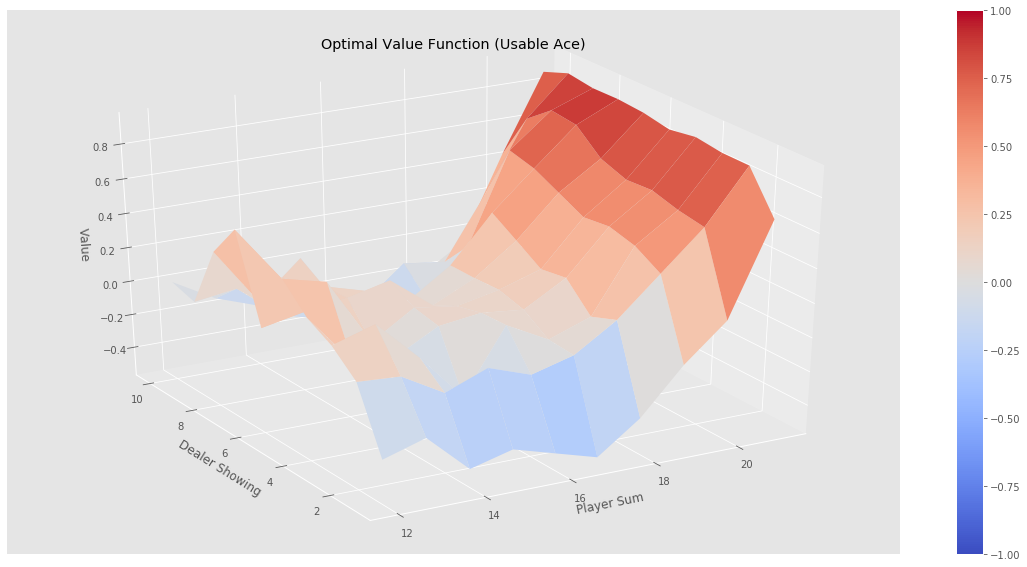

In [20]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")